In [3]:
# import modules
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import sqrt
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import os
import itertools
import pandas as pd

# Coppelia Remote Client
client = RemoteAPIClient()
#sim = client.getObject('sim')

Calibration Classes

In [4]:
class Pattern:
    def __init__(self, pattern_size, square_size, type):
        self.pattern_size = pattern_size
        self.square_size = square_size
        self.type = type
        
        return
    
    def construct3DPoints(self):
        board_points = np.zeros((self.pattern_size[0] * self.pattern_size[1], 3), np.float32)
        board_points[:,:2] = np.mgrid[ 0:self.pattern_size[0], 0:self.pattern_size[1] ].T.reshape(-1,2)
        board_points = board_points * self.square_size
        
        return board_points
    
    def open_scene(self):
        scene_folder = "C:/Users/veloc/Documents/Calibration-Mocap/utils/virtual-calib/scenes/"
        scene_name = self.type + ".ttt"
        sim.loadScene(scene_folder + scene_name)

        return 

In [5]:
class CornerDetector:
    def __init__(self, image_path, pattern_size):
        self.image_path = image_path
        self.pattern_size = pattern_size
        self.criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        
        self.image_points = []
        self.image_size = 0
        return
    
    def detect_using_SB(self):
        # Create empty variables
        images_detected = 0
        
        # For each image in directory
        for image_file in self.image_path:
            # Read the image file
            img = cv2.imread(image_file)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Return the image size
            self.image_size = gray.shape[::-1]
            # Detect the corners in images
            detected, corners = cv2.findChessboardCornersSB(gray, self.pattern_size, None)
            
            if detected:
                # Save corners in image points array
                self.image_points.append(corners)
                images_detected += 1
                
        return images_detected
    def detect_using_subpixel(self):
        # Create empty variables
        images_detected = 0
        
        # For each image in directory
        for image_file in self.image_path:
            # Read the image file
            img = cv2.imread(image_file)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Return the image size
            self.image_size = gray.shape[::-1]
            # Detect the corners in images
            detected, corners = cv2.findChessboardCorners(gray, self.pattern_size, None)
            
            if detected:
                corners = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), self.criteria)
                # Save corners in image points array
                self.image_points.append(corners)
                images_detected += 1
                
            return images_detected            

In [6]:
class Calibrator: 
    def __init__(self, flags_calib, image_path, board_points, image_size, pattern_size):
        self.flags_calib = flags_calib
        self.image_path = image_path

        self.board_points = board_points
        self.image_points = []
        self.world_points = []

        self.image_size = image_size
        self.pattern_size = pattern_size

        self.results = {
        "error_rms": None,
        "camera_matrix": None,
        "distortion_coeffs": None,
        "rvecs": None,
        "tvecs": None,
        "std_intrinsic": None,
        "std_extrinsic": None,
        "per_view_error": None
        }
        return
    
    def prepare_world_points(self):
        
        for i in range(len(self.image_points)):
            self.world_points.append(self.board_points)
        return
    
    def detect_using_SB(self):
        # Create empty variables
        images_detected = 0
        self.image_points = []
        self.world_points = []
        
        # For each image in directory
        for image_file in self.image_path:
            # Read the image file
            img = cv2.imread(image_file)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Return the image size
            self.image_size = gray.shape[::-1]
            # Detect the corners in images
            detected, corners = cv2.findChessboardCornersSB(gray, self.pattern_size, None)
            
            if detected:
                # Save corners in image points array
                self.image_points.append(corners)
                self.world_points.append(self.board_points)
                images_detected += 1
                
        return images_detected
    
    def calibrate(self):
        # Calibrate the camera
        rms, camera_matrix, distortion_coeffs, rvecs, tvecs, std_intrinsic, std_extrinsic, per_view_error = cv2.calibrateCameraExtended(self.world_points, self.image_points, self.image_size, None, None, flags=self.flags_calib)  

        
        # Save the calibration results
        self.results = {
        "error_rms": rms,
        "camera_matrix": camera_matrix,
        "distortion_coeffs": distortion_coeffs,
        "rvecs": rvecs,
        "tvecs": tvecs,
        "std_intrinsic": std_intrinsic,
        "std_extrinsic": std_extrinsic,
        "per_view_error": per_view_error
        }

        #print("Result saved in 'Calibrator.results' ")
        
        return
    
    def calculate_error(self, type, image_path):
        # Create empty arrays for rotation and translation vectors
        rvecs = []
        tvecs = []
        errors = []
        
        # For each image in directory
        for image_file in image_path:
            # Read the image file
            img = cv2.imread(image_file)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Return the image size
            self.image_size = gray.shape[::-1]
            # Detect the corners in images
            detected, corners = cv2.findChessboardCornersSB(gray, self.pattern_size, None)

            # If it was detected
            if detected == True:
                # Calculate extrinsic parameters 
                _, rvec, tvec = cv2.solvePnP(self.board_points, corners, self.results['camera_matrix'], self.results['distortion_coeffs'])
                rvecs.append(rvec)
                tvecs.append(tvecs)

                # Calculate projected image points
                projected_image_points, _ = cv2.projectPoints(self.board_points, rvec, tvec, self.results['camera_matrix'], self.results['distortion_coeffs'])
                
                # Find the Euclidean Distance between projected and detected image points
                if type == 'mean':
                    error = cv2.norm(corners, projected_image_points, normType= cv2.NORM_L2) / len(projected_image_points)
                
                elif type == 'rms':
                    error = cv2.norm(corners, projected_image_points, normType= cv2.NORM_L2) / sqrt(len(projected_image_points))

                errors.append(error)
        return errors
    
    def per_view_error(self):
        image_files = []
        
        # Extract the image file name
        for image in self.image_path:
            nome_arquivo = os.path.basename(image)
            image_files.append(nome_arquivo)

        # Plot the images errors
        plt.figure(figsize=(10,7))
        plt.bar(image_files, self.results['per_view_error'].flatten(), color = 'royalblue', width=.75)

        plt.axhline(y=self.results['error_rms'], color='gray', linestyle='--', linewidth=1)
        
        plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos das imagens para melhor visualização
        plt.tight_layout()  # Ajusta o layout para se encaixar bem na figura
        plt.show()
        
            
    def train_test_split_images(self):
        
        # Step 1 - Initial Calibration
        self.calibrate()
        erros = self.calculate_error('rms', self.image_path)
        median = np.median(erros)
        std = np.std(erros)
        
        # Step 2 - Remove Outliers
        outliers = []
        limiar = median + std
        error = self.results['per_view_error'].flatten()
        
        # Check if the image error is gratter than limiar
        for idx, image in enumerate(self.image_path):
            
            if error[idx] > limiar:
                outliers.append(image)
                
        # Remove outliers from image path    
        for o in outliers:
            print('Remove outlier - ',os.path.basename(o))
            self.image_path.remove(o)

        # Train - Test split
        images_train, images_test, _, _ = train_test_split(self.image_path, np.zeros(len(self.image_path)), test_size = 0.3)
        
        return images_train, images_test

Workflow proposed in **Analysis of camera calibration with respect to measurement accuracy**

In [7]:
# Acquire a set I of original images of the calibration pattern in different orientations.
path = '../../../images/virtual/'
I = glob(path + '7x7/original/set_25/*.jpg')

For this image set $I$, we have $N = 25$ images

In this set $I$, form the an unique subsets with $m$ images. The total of possible unique subsets are going to be $C^N_m$.

In [169]:
# For our case, use m = 10
m = 12
subsets = list(itertools.combinations(I,m))

In [170]:
# The total number of unique subsets are going to be
len(subsets)

5200300

For this subsets, randomly select $n$ subsets to form the powerset $S$

In [171]:
# Using the PCG64DXSM Bit Generator
bit_generator = np.random.PCG64DXSM()
rng = np.random.Generator(bit_generator)


# Select the calibration images subset of size n
n = 200
randoms = rng.choice(np.arange(0,len(subsets)),n, replace=False)

S_subsets = []
for index in randoms:
    S_subsets.append(subsets[index])

Calibrate for each $s$ subset

In [172]:
# Create the calibration pattern
myPattern = Pattern(pattern_size = (7,7),
                    square_size = 30,
                    type = "chessboard_7x7")

# Create Calibrator object
myCalibrator = Calibrator(flags_calib = cv2.CALIB_RATIONAL_MODEL,
                          image_path = I,
                          board_points = myPattern.construct3DPoints(),
                          image_size = (720,720),
                          pattern_size = myPattern.pattern_size)

In [173]:
def extract_camera_parameters(camera_matrix,distortion):
    
    camera_parameters = []
    
    fx,fy = camera_matrix[0][0], camera_matrix[1][1]
    cx,cy = camera_matrix[0][2], camera_matrix[1][2]

    camera_parameters = [fx,fy,cx,cy]

    for i in range(7):
        camera_parameters.append(distortion[0][i])

    return camera_parameters

In [174]:
fx = []
fy = []
cx = []
cy = []
k1 = []
k2 = []
p1 = []
p2 = [] 
k3 = []

for idx, set in enumerate(S_subsets):
    print("Calibration n°", idx + 1)
    myCalibrator.image_path = set
    myCalibrator.detect_using_SB()
    myCalibrator.calibrate()
    camera_matrix = myCalibrator.results['camera_matrix']
    distortion_coeffs = myCalibrator.results['distortion_coeffs']
    camera_params = extract_camera_parameters(camera_matrix,distortion_coeffs)
    fx.append(camera_params[0])
    fy.append(camera_params[1])
    cx.append(camera_params[2])
    cy.append(camera_params[3])
    k1.append(camera_params[4])
    k2.append(camera_params[5])
    p1.append(camera_params[6])
    p2.append(camera_params[7]) 
    k3.append(camera_params[8])

Calibration n° 1
Calibration n° 2
Calibration n° 3
Calibration n° 4
Calibration n° 5
Calibration n° 6
Calibration n° 7
Calibration n° 8
Calibration n° 9
Calibration n° 10
Calibration n° 11
Calibration n° 12
Calibration n° 13
Calibration n° 14
Calibration n° 15
Calibration n° 16
Calibration n° 17
Calibration n° 18
Calibration n° 19
Calibration n° 20
Calibration n° 21
Calibration n° 22
Calibration n° 23
Calibration n° 24
Calibration n° 25
Calibration n° 26
Calibration n° 27
Calibration n° 28
Calibration n° 29
Calibration n° 30
Calibration n° 31
Calibration n° 32
Calibration n° 33
Calibration n° 34
Calibration n° 35
Calibration n° 36
Calibration n° 37
Calibration n° 38
Calibration n° 39
Calibration n° 40
Calibration n° 41
Calibration n° 42
Calibration n° 43
Calibration n° 44
Calibration n° 45
Calibration n° 46
Calibration n° 47
Calibration n° 48
Calibration n° 49
Calibration n° 50
Calibration n° 51
Calibration n° 52
Calibration n° 53
Calibration n° 54
Calibration n° 55
Calibration n° 56
C

In [175]:
dados = {
    'fx': fx,
    'fy': fy,
    'cx': cx,
    'cy': cy,
    'k1': k1,
    'k2': k2,
    'p1': p1,
    'p2': p2,
    'k3': k3
}

df = pd.DataFrame(dados)

In [176]:
# 1. Calcular média e desvio padrão para cada coluna
mean_values = df.mean()
std_values = df.std()

# 2. Criar um DataFrame com os limites inferior e superior
limits = pd.DataFrame({'lower': mean_values - 3 * std_values, 'upper': mean_values + 3 * std_values})

# 3. Filtrar o DataFrame original
D_filtered = df[(df >= limits['lower']) & (df <= limits['upper'])].dropna()

D_filtered

,fx,fy,cx,cy,k1,k2,p1,p2,k3
0,417.653401,417.402374,238.641545,239.041150,-48.303943,700.703683,-0.001182,-0.000179,129.615540
1,416.484904,416.203772,238.923961,239.195702,4.721148,157.231632,-0.001010,-0.000200,-93.680105
2,412.818654,413.009262,239.714094,239.209569,-3.159720,-16.266948,-0.000354,0.000098,53.024691
3,415.074673,415.078559,237.979828,239.120677,-3.681003,-12.605591,-0.000736,-0.000946,46.546367
4,417.669838,417.517292,237.967726,238.675078,-39.561281,512.622715,-0.001171,-0.000727,12.767389
...,...,...,...,...,...,...,...,...,...
195,415.563647,415.469787,239.009885,238.826639,8.620224,-21.371053,-0.000981,-0.000097,25.928653
196,417.705281,417.543454,238.722729,238.593923,-10.198338,-20.669006,-0.000887,-0.000413,318.226834
197,418.585072,418.162756,239.540871,240.380111,25.919420,-8.069482,0.000370,0.000205,-296.442764
198,415.209487,415.107806,238.721042,240.322905,-47.519086,538.269954,-0.000164,-0.000463,680.728731


In [177]:
def recover_camera_params(df_mean_values):
    fx = df_mean_values.iloc[0]
    fy = df_mean_values.iloc[1]
    cx = df_mean_values.iloc[2]
    cy = df_mean_values.iloc[3]
    
    camera_matrix = np.array([[ fx,   0, cx],
                              [  0,  fy, cy],
                              [  0,   0,  1]])

    k1 = df_mean_values.iloc[4] 
    k2 = df_mean_values.iloc[5]    
    p1 = df_mean_values.iloc[6]    
    p2 = df_mean_values.iloc[7]    
    k3 = df_mean_values.iloc[8]
    k4 = 0
    k5 = 0
    k6 = 0
    k7 = 0
    k8 = 0
    k9 = 0
    k10 = 0
    k11 = 0
    k12 = 0
    
    distortion_coeffs = np.array([[k1,k2,p1,p2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12]])
    
    
    return camera_matrix, distortion_coeffs

In [178]:
camera_matrix, distortion_coeffs = recover_camera_params(D_filtered.mean())

In [179]:
def calculate_error(Calibrator, type, image_path, camera_matrix, distortion_coeffs):
        # Create empty arrays for rotation and translation vectors
        rvecs = []
        tvecs = []
        errors = []
        
        # For each image in directory
        for image_file in image_path:
            # Read the image file
            img = cv2.imread(image_file)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Return the image size
            Calibrator.image_size = gray.shape[::-1]
            # Detect the corners in images
            detected, corners = cv2.findChessboardCornersSB(gray, Calibrator.pattern_size, None)

            # If it was detected
            if detected == True:
                # Calculate extrinsic parameters 
                _, rvec, tvec = cv2.solvePnP(Calibrator.board_points, corners, camera_matrix, distortion_coeffs)
                rvecs.append(rvec)
                tvecs.append(tvecs)

                # Calculate projected image points
                projected_image_points, _ = cv2.projectPoints(Calibrator.board_points, rvec, tvec, camera_matrix, distortion_coeffs)
                
                # Find the Euclidean Distance between projected and detected image points
                if type == 'mean':
                    error = cv2.norm(corners, projected_image_points, normType= cv2.NORM_L2) / len(projected_image_points)
                
                elif type == 'rms':
                    error = cv2.norm(corners, projected_image_points, normType= cv2.NORM_L2) / sqrt(len(projected_image_points))

                errors.append(error)
        return errors

In [180]:
np.mean(calculate_error(myCalibrator,'rms',subsets[0],camera_matrix,distortion_coeffs))

20.510071872077795

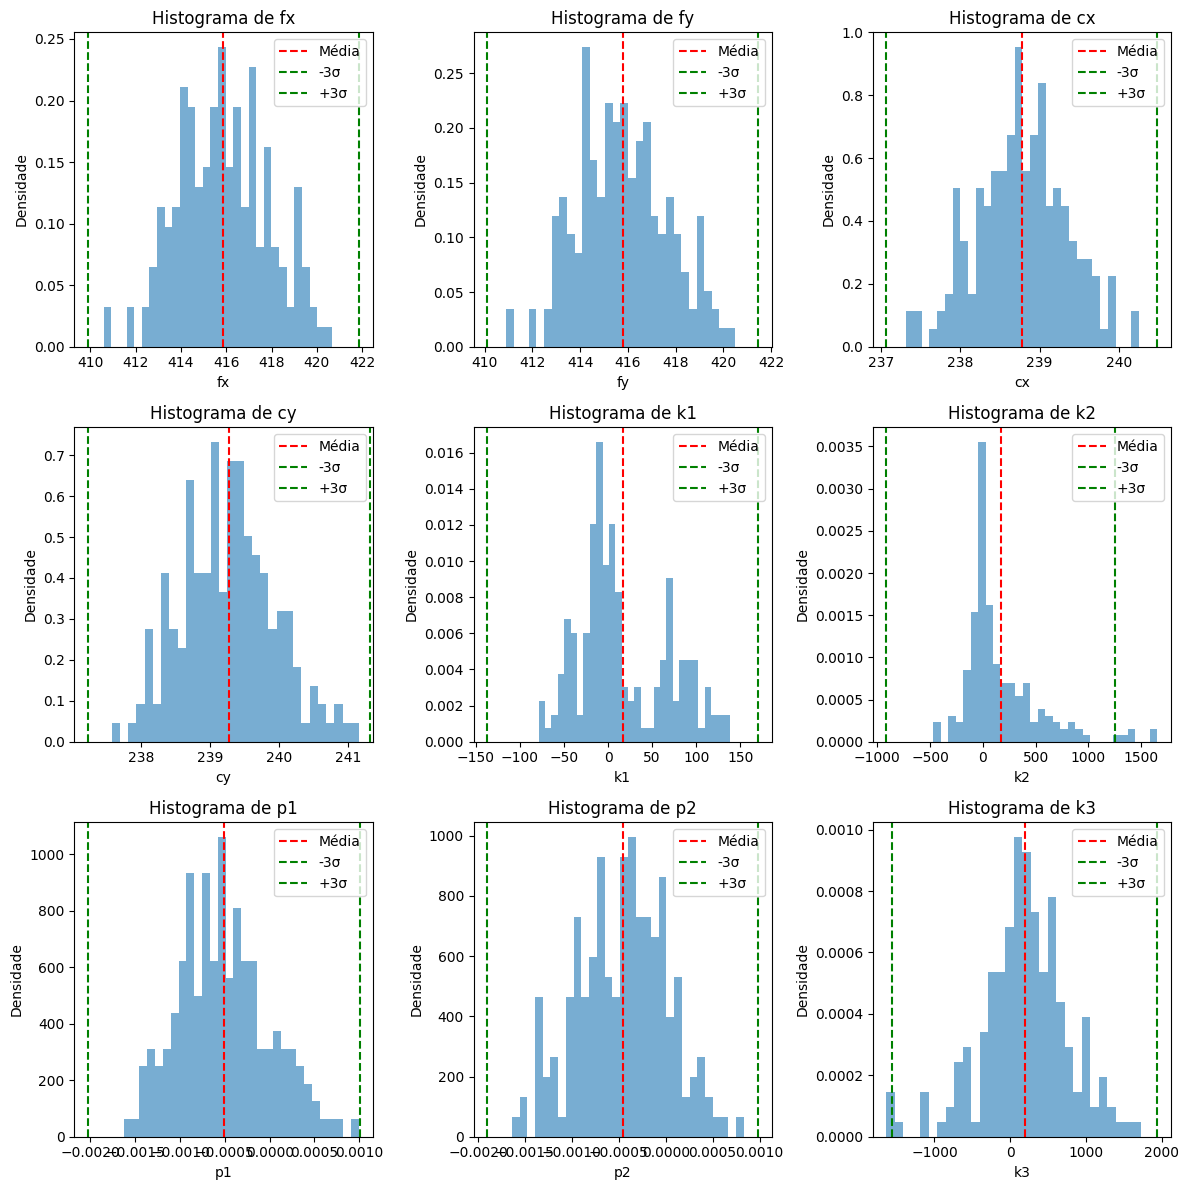

In [181]:
# Função para criar um histograma para um parâmetro específico em um subplot
def plot_histograma(df, parametro, ax):
    ax.hist(df[parametro], bins=30, density=True, alpha=0.6)
    ax.set_xlabel(parametro)
    ax.set_ylabel('Densidade')
    
    # Calculando média e desvios padrão
    media = df[parametro].mean()
    desvio_padrao = df[parametro].std()
    
    # Plotando a média e os limites
    ax.axvline(x=media, color='red', linestyle='--', label='Média')
    ax.axvline(x=media - 3*desvio_padrao, color='green', linestyle='--', label='-3σ')
    ax.axvline(x=media + 3*desvio_padrao, color='green', linestyle='--', label='+3σ')
    
    ax.legend()
    ax.set_title(f'Histograma de {parametro}')

# Criando uma figura com subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.flatten()

# Criando histogramas para todos os parâmetros
parametros = ['fx', 'fy', 'cx', 'cy', 'k1', 'k2', 'p1', 'p2', 'k3']
for i, parametro in enumerate(parametros):
    plot_histograma(D_filtered, parametro, axes[i])

plt.tight_layout()
plt.show()